<a href="https://colab.research.google.com/github/rpizarrog/innovacion-empresarial/blob/main/notebook_python/Caso_01_Regresi%C3%B3n_Lineal_Simple_Estaturas_Pesos_Personas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo

Construir y evaluar un modelo de regresión lineal simple con dos variables numéricas que definen una variable independiente y otra variable dependiente.

Para este caso se carga un conjunto de datos con valores numéricos de:

* *estaturas* como variable independiente y
* *pesos* como variable dependiente.


# Descripción

* Cargar librerías.
* Crear funciones.
* Cargar datos.
* Análisis descriptivo exploratorio.
  * Visualizar datos.
    * Histograma.
    * Diagrama de caja.
    * Dispersión de los datos.
*  Crear modelo de regresión lineal simple.
  * Identificar métricas *r square* con valor por encima del $50$% para aceptar el modelo y de *RMSE* cercano a 0 que deberá ser comparado con otro modelo de regresión.
  * Partir en datos de entrenamiento y datos de validación con el $80$% y $20$%.
  * Evaluar modelo con datos de entrenamiento con el valor *r square*.
  * Visualizar recta de regresión con el modelo construído y los datos de entrenamiento.
  * Realizar predicciones utilizando el modelo con los datos de validación.
  * Evaluar el modelo con el estadístico RMSE *root mean square error*
* Interpretar el caso.


# Dearrollo

## Cargar librerías


In [7]:
import pandas as pd
import numpy as np
from collections import Counter as Counter
import math
from sklearn.linear_model import LinearRegression # Para contruir el modelo

import matplotlib.pyplot as plt # Para visualizar datos
from sklearn.model_selection import train_test_split # Para partir los datos

from sklearn import metrics # Para determinar métricas.



## Crear funciones

Se crean funciones personalizadas útiles el el desarrollo del caso.


In [35]:
# Esta función regresa los datos en formato csv cargados en memoria RAM
def f_cargar_datos(ruta):
  # Cargar datos de la carpeta sample_data
  # datos = pd.read_csv('sample_data/estaturas_pesos.csv')

  # cargar datos de github.com enlace en la nube internet
  datos = pd.read_csv(ruta)
  return datos

# Función que devuelve estad´siticos de una variable numérica
def f_media_moda_mediana_n(datos):
  # Calcular la media aritmética
  media = np.mean(datos)

  # Calcular la moda
  contador = Counter(datos)
  moda = contador.most_common(1)[0][0]

  # Calcular la mediana
  mediana = np.median(datos)

  # ¿Cuántos nnpúmeros son?
  n = len(datos)
  return media, moda, mediana, n

# Función que devuelve las medias aritméticas y desviaciones estándar de dos variables numéricas de una muestra
def f_medias (independiente, dependiente):
  medias = [np.mean(independiente), np.mean(dependiente)]
  return medias

# Función que devuelve las desviaciones estándar de dos variables numéricas de una muestra
def f_desviaciones_std (independiente, dependiente):
  desviaciones = [np.std(independiente, ddof=1), np.std(dependiente, ddof=1)]
  return desviaciones

# Función que devuelve la covariana y correlación de Pearson y r square de dos variables numéricas de una muestra
def f_cov_corr(independiente, dependiente):
  covar = np.cov(independiente, dependiente, ddof=1)[0,1]
  r = np.corrcoef(independiente, dependiente)[0,1]
  r_square = r ** 2
  return covar, r, r_square


# Función que construye diagrama de dispersión
def f_dispersion (x, y, x_nombre, y_nombre):
  medias = f_medias(x, y)

  cova, r, r_square = f_cov_corr(x, y)   # Crear el diagrama de dispersión
  plt.scatter(x, y, s = 5)

  # Etiquetas y título
  plt.xlabel(x_nombre)
  plt.ylabel(y_nombre)
  plt.title(print('Diagrama de Dispersión. Corr Pearson'))

  plt.axvline(x=medias[0], color='blue', linestyle='--', linewidth=0.5,
            label="Media "+ x_nombre + ":" + str(np.round(medias[0], 2)))
  plt.axhline(y=medias[1], color='green', linestyle='--', linewidth=0.5,
            label="Media "+ y_nombre+":" + str(np.round(medias[1], 2)))
  plt.legend()

  # Subtítulo debajo del gráfico
  plt.figtext(0.5, -0.05, f'R Pearson: {np.round(r, 4)}', ha='center', fontsize=10)

  # Mostrar el diagrama de dispersión
  plt.show()

# función que visualiza histograma de una variable numérica en estructira tipo lista
# Re Utiliza la función f_media_moda_mediana_n
def f_histograma(datos, contexto):
  min = np.min(datos)
  max = np.max(datos)

  # Calcular el número óptimo de clases usando la regla de Sturges
  n = len(datos)
  k = int(round(1 + math.log2(n)))

  plt.hist(datos, bins=range(min, max, k), edgecolor="black")
  plt.xlabel(contexto)

  media, moda, mediana, N = f_media_moda_mediana_n(datos)

  # Agregar líneas punteadas roja, azul y verde para representar media, mediana y moda
  medias = f_media_moda_mediana_n(datos)
  plt.axvline(x=media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
  plt.axvline(x=mediana, color='blue', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.2f}')
  plt.axvline(x=moda, color='yellow', linestyle='--', linewidth=2, label=f'Moda: {moda:.2f}')

  plt.ylabel("Frecuencia")
  plt.title("Distribución de los datos: "+contexto)

  plt.legend()
  plt.grid(False)
  plt.show()

# Calcula los cuartiles
def f_cuartiles_quantile(datos):
  q1 = np.percentile(datos, 25)
  q2 = np.percentile(datos, 50)
  q3 = np.percentile(datos, 75)
  return q1, q2, q3

# Visualiza diagrama de caja para indentificar datos extremos
def f_diagrama_caja (datos, contexto):
  plt.boxplot(datos, vert=False)
  plt.xlabel(contexto)
  plt.ylabel('Valor')
  plt.title('Diagrama de Caja')

  # Calculando cuartiles d ela funci´pn previamente creada
  q1, q2, q3= f_cuartiles_quantile(datos)
  # Añadir leyendas para los cuartiles
  plt.axvline(x=q1, color='blue', linestyle='--', linewidth=1, label=f'Q1: {q1:.2f}')
  plt.axvline(x=q2, color='blue', linestyle='--', linewidth=1, label=f'Q2:Mediana: {q2:.2f}')
  plt.axvline(x=q3, color='blue', linestyle='--', linewidth=1, label=f'Q3: {q3:.2f}')

  # Añadir leyenda adicional
  plt.legend()

  plt.show()


# función que visualzia la recta de regesi,ón
# Graficar los datos y la regresión lineal
def f_regresion(modelo):
  plt.scatter(estaturas, pesos, color='blue', s=5)
  #plt.plot(estaturas, modelo.predict(estaturas), color='red', label = "")
  plt.plot(estaturas, modelo.predict(estaturas), color='red', linewidth=0.5, label=f'a = {a}; b = {b}')

  plt.xlabel('Estatura (cm)')
  plt.ylabel('Peso (kg)')
  plt.title('Regresión Lineal Simple')
  plt.legend()
  plt.grid(True)

# Esto debe ser una función

def f_regresion_linea_tendencia(modelo, x, y, x_nombre, y_nombre):
  # Graficar los datos y la regresión lineal
  plt.scatter(x, y, color='blue', s=5)
  a = modelo.intercept_  # El alor de la intersección de la abcisa
  b = modelo.coef_       # El valor de la pendiente

  # Datos de cova y correlacion con los valores de entrenamiento
  covar, r, r_square = f_cov_corr(x, y)

  # Líena de tendencia
  linea_tendencia = modelo.predict(x.reshape(-1, 1))
  plt.plot(x.reshape(-1, 1), linea_tendencia, color='red', linewidth=0.5,
           label=f'a = {np.round(a, 4)}; b = {np.round(b, 4)}; r={np.round(r, 4)}; r square = {np.round(r_square, 4)}')

  plt.xlabel(x_nombre)
  plt.ylabel(y_nombre)
  plt.title('Regresión Lineal Simple. Datos de Entrenamiento')
  plt.legend()
  plt.grid(True)



## Crear o cargar datos

Se cargan los datos de la ruta *url* indicada en donde están los datos en un formato de *archivo csv* que supone contiene dos variables numéricas en donde la primera variable o columna es la variable independiente y la segunda columna es la variable dependiente.

Ejemplo *estaturas* como variable independiente y *pesos* como variable dependiente.


In [13]:
# https://raw.githubusercontent.com/rpizarrog/innovacion-empresarial/refs/heads/main/datos/estaturas_pesos.csv
ruta = "https://raw.githubusercontent.com/rpizarrog/innovacion-empresarial/refs/heads/main/datos/estaturas_pesos.csv"
datos = f_cargar_datos(ruta)

print(datos)




    estaturas  pesos
0         178     79
1         172     75
2         160     62
3         192    107
4         167     72
..        ...    ...
57        170     75
58        180     85
59        180     95
60        170     75
61        172     78

[62 rows x 2 columns]


Mostrar la estructura del conjunto de datos conla función *info()*.

In [14]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   estaturas  62 non-null     int64
 1   pesos      62 non-null     int64
dtypes: int64(2)
memory usage: 1.1 KB



## Análisis descriptivo

Se presentan los estadísticos mas importantes de las variables de interés con la función *describe()*

Se define independiente = 'estaturas'
Se define dependiente = 'pesos'

### Estadísticos

In [15]:
independiente = 'estaturas'
dependiente = 'pesos'

datos[[independiente, dependiente]].describe()

,estaturas,pesos
count,62.000000,62.000000
mean,172.032258,74.806452
std,9.042645,11.297524
min,150.000000,52.000000
25%,165.000000,67.250000
50%,170.000000,75.000000
75%,178.000000,80.000000
max,192.000000,107.000000


### Histograma

Histograma de las variables de interés estaturas y de pesos.

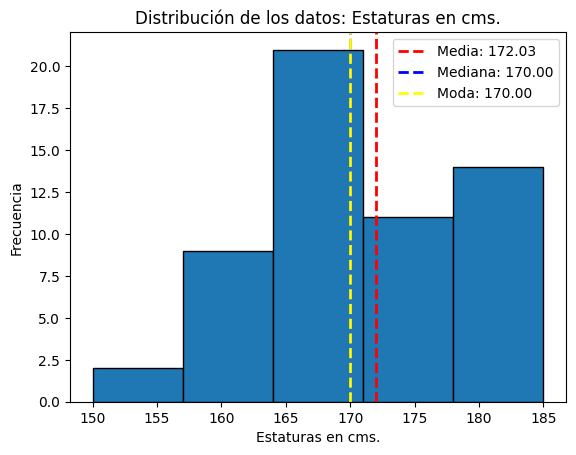

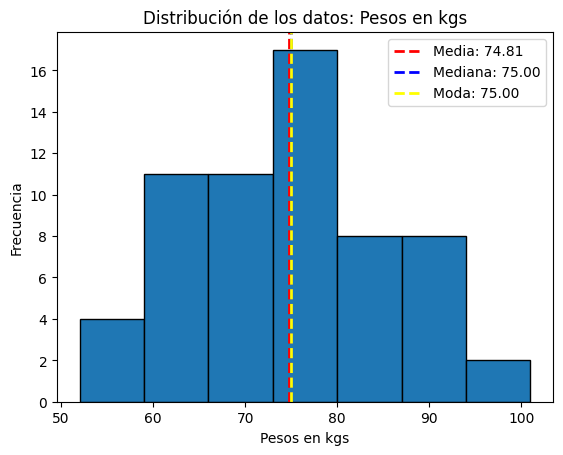

In [16]:
f_histograma(datos[independiente], "Estaturas en cms.")

f_histograma(datos[dependiente], "Pesos en kgs")


### Diagramas de caja

Se exploran los datos mediante el diagrama de caja de las variables de interés estaturas y pesoso para identifiar si hay valores atípicos.

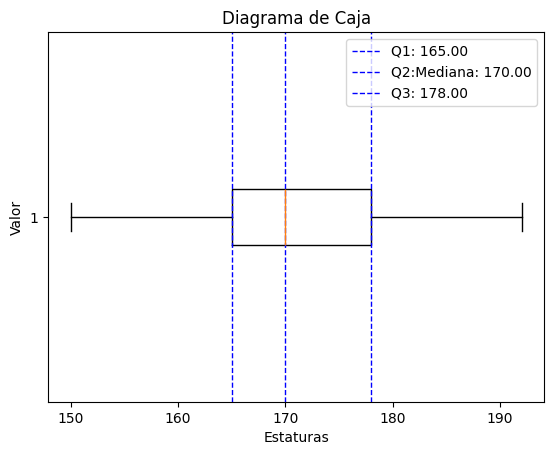

In [17]:
f_diagrama_caja(datos[independiente], "Estaturas")

No hay valores atípicos en los valores de la variable estaturas.

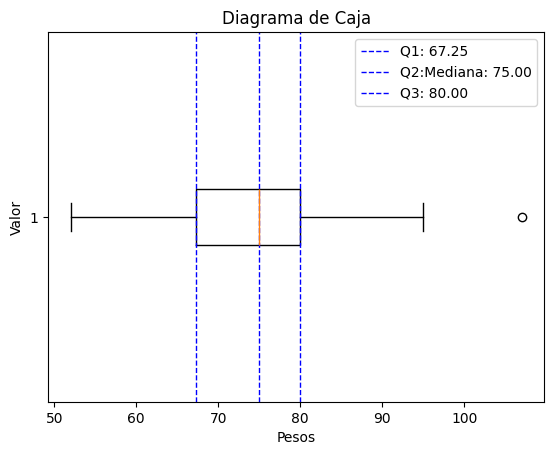

In [18]:
f_diagrama_caja(datos[dependiente], "Pesos")

Existe un valor atípico en la variable peos por encima de 100 o más kgs.

La pregunta es, ¿qué hacer con ese dato?, verificarlo y dejarlo o modificar su valor y transformarlo a un valor numéricos veraz, viable o verificable que ouede ser el valor de la media aritmética o la mediana.

### Dispersión de los datos



Diagrama de Dispersión. Corr Pearson


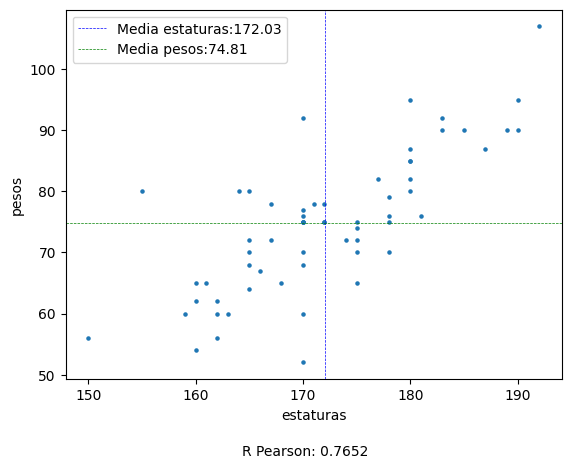

In [19]:
f_dispersion(datos[independiente], datos[dependiente], "estaturas", "pesos")


La correlación *r* resultante de los datos de *estatura*  y *peso* fue de $0.7652$ que se interpreta como una correlación positiva fuerte.

## Crear modelo de regresión lineal simple.

### Preparar datos

Se extraen las variables estaturas y pesos a tipo de datos listas numpy para facilitar su uso.

In [41]:
v_independiente = datos[independiente].to_numpy()
v_dependiente = datos[dependiente].to_numpy()

print (v_independiente)
print(v_dependiente)




[178 172 160 192 167 170 185 175 180 170 180 180 170 183 161 150 162 177
 190 165 164 183 175 168 170 175 175 178 170 160 162 166 178 170 163 165
 170 167 159 165 181 170 172 171 178 165 162 187 189 174 160 190 155 180
 175 170 165 170 180 180]
[ 79  75  62 107  72  52  90  70  85  92  87  82  75  90  65  56  56  82
  95  70  80  92  74  65  77  72  65  70  75  65  60  67  75  70  60  72
  76  78  60  68  76  60  75  78  76  64  62  87  90  72  54  90  80  80
  75  68  80  75  85  95]


## Crear datos de entrenamiento y validación

* Los datos de entrenamiento serán aleatoriamente el 80% de los datos originales.
* Los datos de validación o prueba (test) serán aleatoriamente el complemento del 20%.
* Los datos de entrenamiento y datos de validación deben
set mutuamente excluyentes que signifia que están en uno conjunto o están en el otro.

Ahora que se tiene la variable independiente estaturas y la variable dependiente pesos, el siguiente paso es dividir estos datos en conjuntos de entrenamiento y prueba o validación.

Se utiiza el método *train_test_split()* que forma parte de la librería Scikit-Learn para dividir los datos en entrenamiento y validación.

El argumento *test_size* establece el 20% para datos de validación por lo que el $80$% pertenece a los datos de entrenamiento y el resto a datos de validación o prueba.

In [28]:

v_independiente = datos[independiente].to_numpy()
v_dependiente = datos[dependiente].to_numpy()

ind_train, ind_test, dep_train, dep_test = train_test_split(v_independiente, v_dependiente,
                                                                            test_size=0.2,
                                                                            random_state=2025)

# Crear un DataFrame con los datos de entrenamiento
datos_entrenamiento = pd.DataFrame({independiente: ind_train, dependiente: dep_train})

# Datos de entrenamiento
print ("Datos de entrenamiento")
print(datos_entrenamiento)

# Crear un DataFrame con los datos de validación o test
datos_validacion = pd.DataFrame({independiente: dep_test, dependiente: dep_test})


# Datos de validación
print()
print ("Datos de validación")
print(datos_validacion)



Datos de entrenamiento
    estaturas  pesos
0         180     85
1         159     60
2         174     72
3         178     76
4         171     78
5         166     67
6         165     64
7         170     52
8         183     92
9         150     56
10        170     77
11        189     90
12        167     72
13        160     54
14        180     80
15        175     65
16        170     68
17        183     90
18        178     70
19        170     92
20        170     75
21        170     60
22        180     82
23        172     75
24        177     82
25        175     72
26        170     76
27        170     75
28        178     79
29        162     56
30        164     80
31        162     62
32        168     65
33        190     90
34        181     76
35        170     70
36        161     65
37        180     87
38        167     78
39        175     74
40        178     75
41        180     85
42        165     70
43        192    107
44        165     80
45        1

## Construir el modelo

Se construye el modelo de regresión lineal simple y se ajusta con **los datos de entrenamiento**.

La función *reshape()* significa que los valores se reciben de manera bidimensional porque así los necesita el modelo.

In [23]:

modelo = LinearRegression()
modelo.fit(ind_train.reshape(-1, 1), dep_train.reshape(-1, 1))


LinearRegression()

### Coeficientes

Se extraen los coeficienes $a$ y $b$ de la fórmula de mínimos cuadrados:

$$
\text{Predicción Y = } a + b\cdot x_i
$$
ó
$$
\text{Predicción Y = } \beta_0 + \beta_1\cdot x_i
$$


¿Cómo calcular $a$ y $b$ o $\beta_0$  y $β_1$?

### Calcula la pendiente b
$$
b = r \cdot \frac{s_y}{s_x}
$$

* r es la Correlación de *Pearson*
* $S_y$ es la desviación estándar de y
* $S_y$ es la desviación estándar de x

### Cacular la abcisa a

$$
a = \bar{y} - b \cdot \bar{x}
$$

* $\bar{y}$ la media de $y$
* $\bar{x}$ la media de $x$
* $b$ la pendiente previamente calculada


In [37]:
a = modelo.intercept_  # El valor de la intersección o la abcisa a
b = modelo.coef_       # El valor de la pendiente b
print ("Coeficiente a :", a)
print ("Coeficiente b :", b)


Coeficiente a : [-103.27654882]
Coeficiente b : [[1.03200271]]


El modelo de regesión lineal simple arroja los valores de los coeficiente a y b de $-103.2765$ y $1.0320$ respectivamente, habiuendi particionado los datos de entrenamiento al $80$% y $20$% datos de validación con una semilla de aleatoriedad del $2025$.


### Recta de regresión

Se manda llamar la función *f_regresion_linea_tendencia()* para observar la recta de regresión.

<ipython-input-35-7d3cff9fd9eb>:38: RuntimeWarning: Degrees of freedom <= 0 for slice
  covar = np.cov(independiente, dependiente, ddof=1)[0,1]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


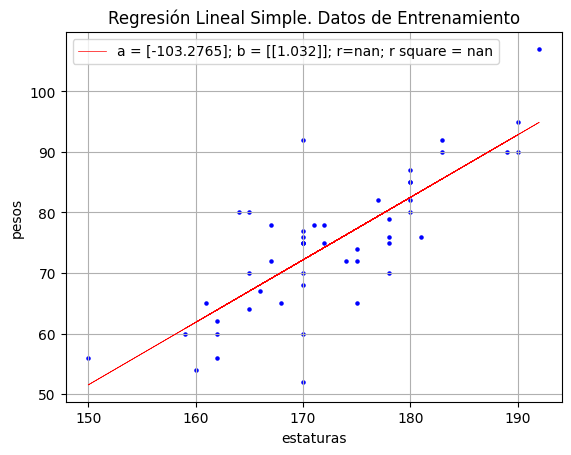

In [36]:
f_regresion_linea_tendencia(modelo, ind_train.reshape(-1, 1), dep_train.reshape(-1, 1), independiente, dependiente)


# Pendiente algún error



## Métricas de evaluación

El modelo se acepta si el valor de *r square* sobrepasa el $50$% tanto con los datos de entrenamiento como con los datos de validación.

El modelo a través de la métrica *root mean square error (RMSE)* que significa que tanto varía las predicciones con respecto a los datos reales se deberá comparar con otros modelos y los mismos datos para evalura su rendimiento.



## Métrica r square

In [38]:
# Calcular el coeficiente de determinación R^2 o R square
score = modelo.score(ind_train.reshape(-1, 1), dep_train.reshape(-1, 1))
print("Coeficiente de determinación R^2:", score)

Coeficiente de determinación R^2: 0.6206686345839262


La métrica de *r square* está por encima del $50$% por lo que el modelo SI se acepta y significa que la variable estatura de una persona representa o explica aproximadamente un $62.06$% a la variable peso de la misma persona.

## Predicciones

¿Cuál es la predicción para valores de acuerdo al modelo de regresión lineal simple?
$$
\text{Predicción Y} = -103.27654882 + 1.03200271] \cdot x_i
$$

Se utilizan los datos de validación de la variable pesos para hacer las predicciones



In [39]:
predicciones = modelo.predict(ind_test.reshape(-1, 1))
print(predicciones)

[[89.70795755]
 [56.6838709 ]
 [77.32392505]
 [67.00389798]
 [72.16391151]
 [74.22791693]
 [67.00389798]
 [64.93989256]
 [61.84388444]
 [61.84388444]
 [82.48393859]
 [87.64395213]
 [77.32392505]]


Crear un *data.frame* llamado comparaciones a partir de la creación de un diccionario con los valores reales del conjunto de validacipon y las predicciones calculadas.

Con la función flatten().tolist() convierte el arreglo a una lista de una dimensión.

In [40]:

diccionario = {independiente: ind_test.flatten().tolist(),
                'Real' : dep_test.flatten().tolist(),
               'Predicho' : predicciones.flatten().tolist() }
# diccionario

comparaciones = pd.DataFrame(diccionario)
print (comparaciones)

    estaturas  Real   Predicho
0         187    87  89.707958
1         155    80  56.683871
2         175    75  77.323925
3         165    68  67.003898
4         170    75  72.163912
5         172    75  74.227917
6         165    72  67.003898
7         163    60  64.939893
8         160    62  61.843884
9         160    65  61.843884
10        180    95  82.483939
11        185    90  87.643952
12        175    70  77.323925


¿Qué tanto se desvián las predicciones de los valores reales?

Error estándar médio MSE
$$
MSE = \frac{\sum(predicho_i - real_i)^{2}}{n}
$$

Raiz del error estándar medio *Root Mean Square Error*

$$
RMSE = \sqrt{\frac{\sum(predicho_i - real_i)^{2}}{n}}
$$

In [41]:
print('Mean Absolute Error: MAE', metrics.mean_absolute_error(dep_test, predicciones))
print('Mean Squared Error: MSE', metrics.mean_squared_error(dep_test, predicciones))
print('Root Mean Squared Error RMSE:', np.sqrt(metrics.mean_squared_error(dep_test, predicciones)))

cova, r, r_square =  f_cov_corr(ind_test, dep_test)
print ("r square = ", r_square)



Mean Absolute Error: MAE 5.261272717193925
Mean Squared Error: MSE 64.70760860217702
Root Mean Squared Error RMSE: 8.04410396515218
r square =  0.5115185155855867


# Interpretación

pendiente ...

Se cargó un conjunto de datos con variables de interés estaturas y pesos corporales de personas.

Se exploraron estadísticos de los datos observándose que no existen datos atípicos.

Se construyó un modelo de regresión lineal simple con datos de entrenamiento. La variable estaturas fué la variable predictora o independiente y la variable peso fue la variable predictiva, objetivo o dependiente.

A partir del modelo de regresión lineal simple se extrajeron los coeficientes de la abcisa o intersección  a  y la pendiente  b  teniendo valores de  $a=-103.2765$  y  $b=1.0320$ , que son los valores de los coeficientes que definen la recta de regresión o recta de estimación para cada valor de la variable independoiente.

* Coeficiente a : [-103.27654882]
* Coeficiente b : [[1.03200271]]


Se visualizó la dispersión de los datos con los valores de entrenamiento y se estimó la recta de regresión presentada también visualmente.

Habiendo relizado una evaluación del modelo con datos de entrenamiento o datos que se utilizaron para construir el modelo con el estadístico *r square* o coeficiente de determinación se encontró que el valor de estaturas representa aproximadamente un  $62$ % al valor del peso corporal de una persona.

Se utilizaron datos de prueba o datos de validación con las mismas variables de estaturas y pesos para construir predicciones.

Habiendo relizado una evaluación del modelo con los datos de validación o datos de prueba con el estadístico *r square* o coeficiente de determinación se encontró que el valor de estatura representa aproximadamente un  $62$% al valor del peso corporal de una persona.

El modelo se acepta datos que el valor de *r square* como métrica establecida inicialmente sobrepasa el  $50$% tanto con los datos de entrenamiento como con los datos de validación.

El valor de *RMSE* *root mean square error* o error cuadrático medio significa eu tanto el modelo es eficiente y su valor cercano a cero representa esa eficiencia. El valor fue de   $8.04$  aproximadamente y debe ser comparado contra otro modelo para medir su eficiencia en relación con otros.

!Hasta la próxima!

